<a href="https://colab.research.google.com/github/sun-fox/self-driving-car/blob/master/DRT_autonomous_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [2]:
!ls track

driving_log.csv  IMG


In [3]:
!pip3 install imgaug

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import tensorflow
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization
from imgaug import augmenters as iaa
import random
import ntpath

In [5]:
datadir = 'track'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'),names=columns)
pd.set_option('display.max_colwidth',None)
data.head()

center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

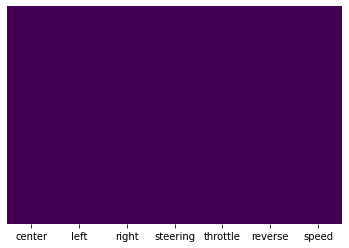

In [6]:
import seaborn as sns
sns.heatmap(data.isnull(),yticklabels=False,cbar=False, cmap='viridis')

In [7]:
def path_leaf(path):
  head,tail = ntpath.split(path)
  return tail

data['center']=data['center'].apply(path_leaf)
data['left']=data['left'].apply(path_leaf)
data['right']=data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

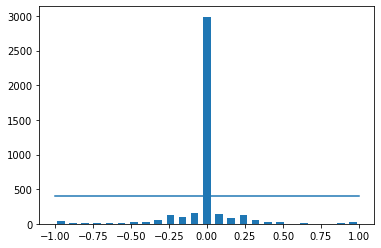

In [8]:
num_bins = 25 
samples_per_bin = 400
hist, bins = np.histogram(data['steering'],num_bins)
center = ((bins[:-1] + bins[1:]))*0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

In [9]:
data['steering']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4048    0.0
4049    0.0
4050    0.0
4051    0.0
4052    0.0
Name: steering, Length: 4053, dtype: float64

total data: 4053
removed: 2590
remaining: 1463


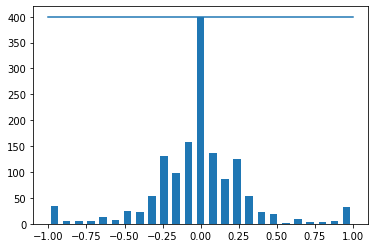

In [10]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  lst = []
  for i in range(len(data['steering'])):
    if(data['steering'][i]>=bins[j] and data['steering'][i]<bins[j+1]):
      lst.append(i)
  lst = shuffle(lst)
  lst = lst[samples_per_bin:]
  remove_list.extend(lst)

print('removed:',len(remove_list))
data.drop(data.index[remove_list],inplace=True)
print('remaining:',len(data))

hist, _ = np.histogram(data['steering'],(num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

In [11]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG',data)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths,steerings,test_size=0.2,random_state=6)
print('Training Samples: {}\n Valid Samples: {}'.format(len(X_train),len(X_valid)))

Training Samples: 1170
 Valid Samples: 293


Text(0.5, 1.0, 'Validation set')

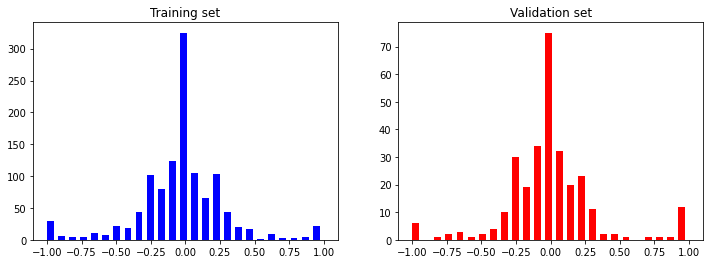

In [13]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train,bins=num_bins,width=0.05,color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [14]:
def zoom(image):
  zoom = iaa.Affine(scale=(1,1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'zoomed Image')

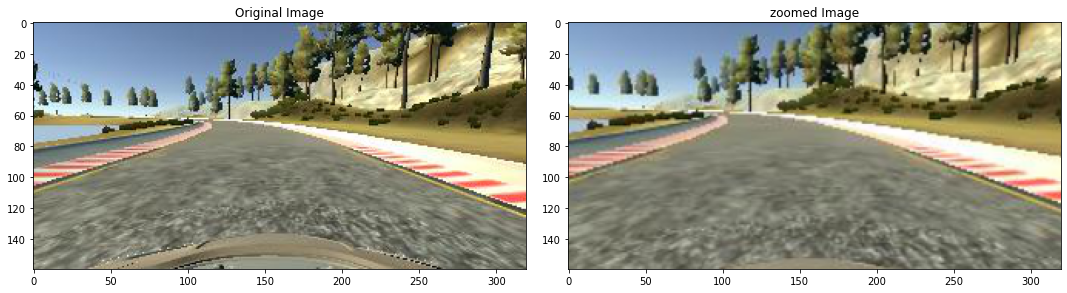

In [15]:
image = image_paths[random.randint(0,1000)]
original_img = mpimg.imread(image)
zoomed_img = zoom(original_img)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_img)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_img)
axs[1].set_title('zoomed Image')

In [16]:
def pan(image):
  pan = iaa.Affine(translate_percent = {"x" : (-0.1,0.1), "y" : (-0.1,0.1)})
  img = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

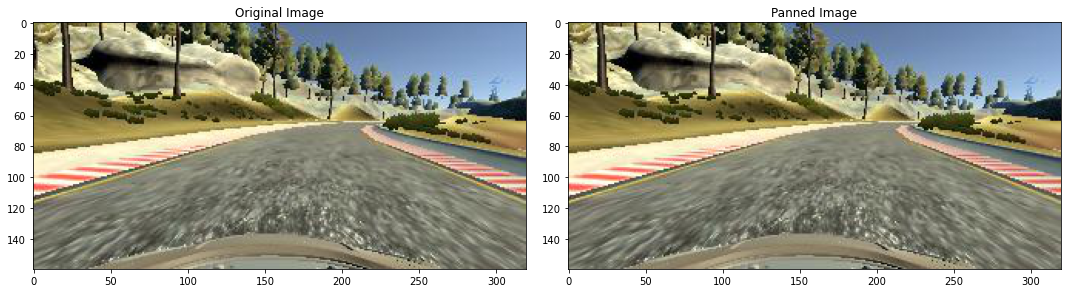

In [17]:
image = image_paths[random.randint(0,1000)]
original_img = mpimg.imread(image)
panned_img = pan(original_img)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_img)
axs[0].set_title('Original Image')

axs[1].imshow(panned_img)
axs[1].set_title('Panned Image')

In [18]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1.0, 'Brightness altered image ')

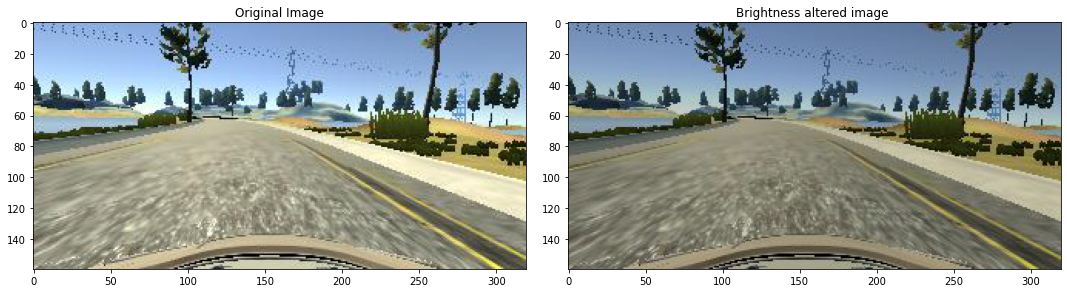

In [19]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

In [20]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle:-0.0')

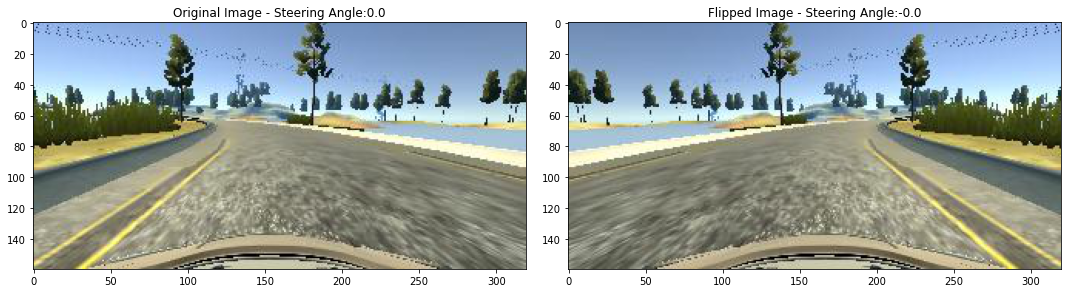

In [21]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]


original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [22]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

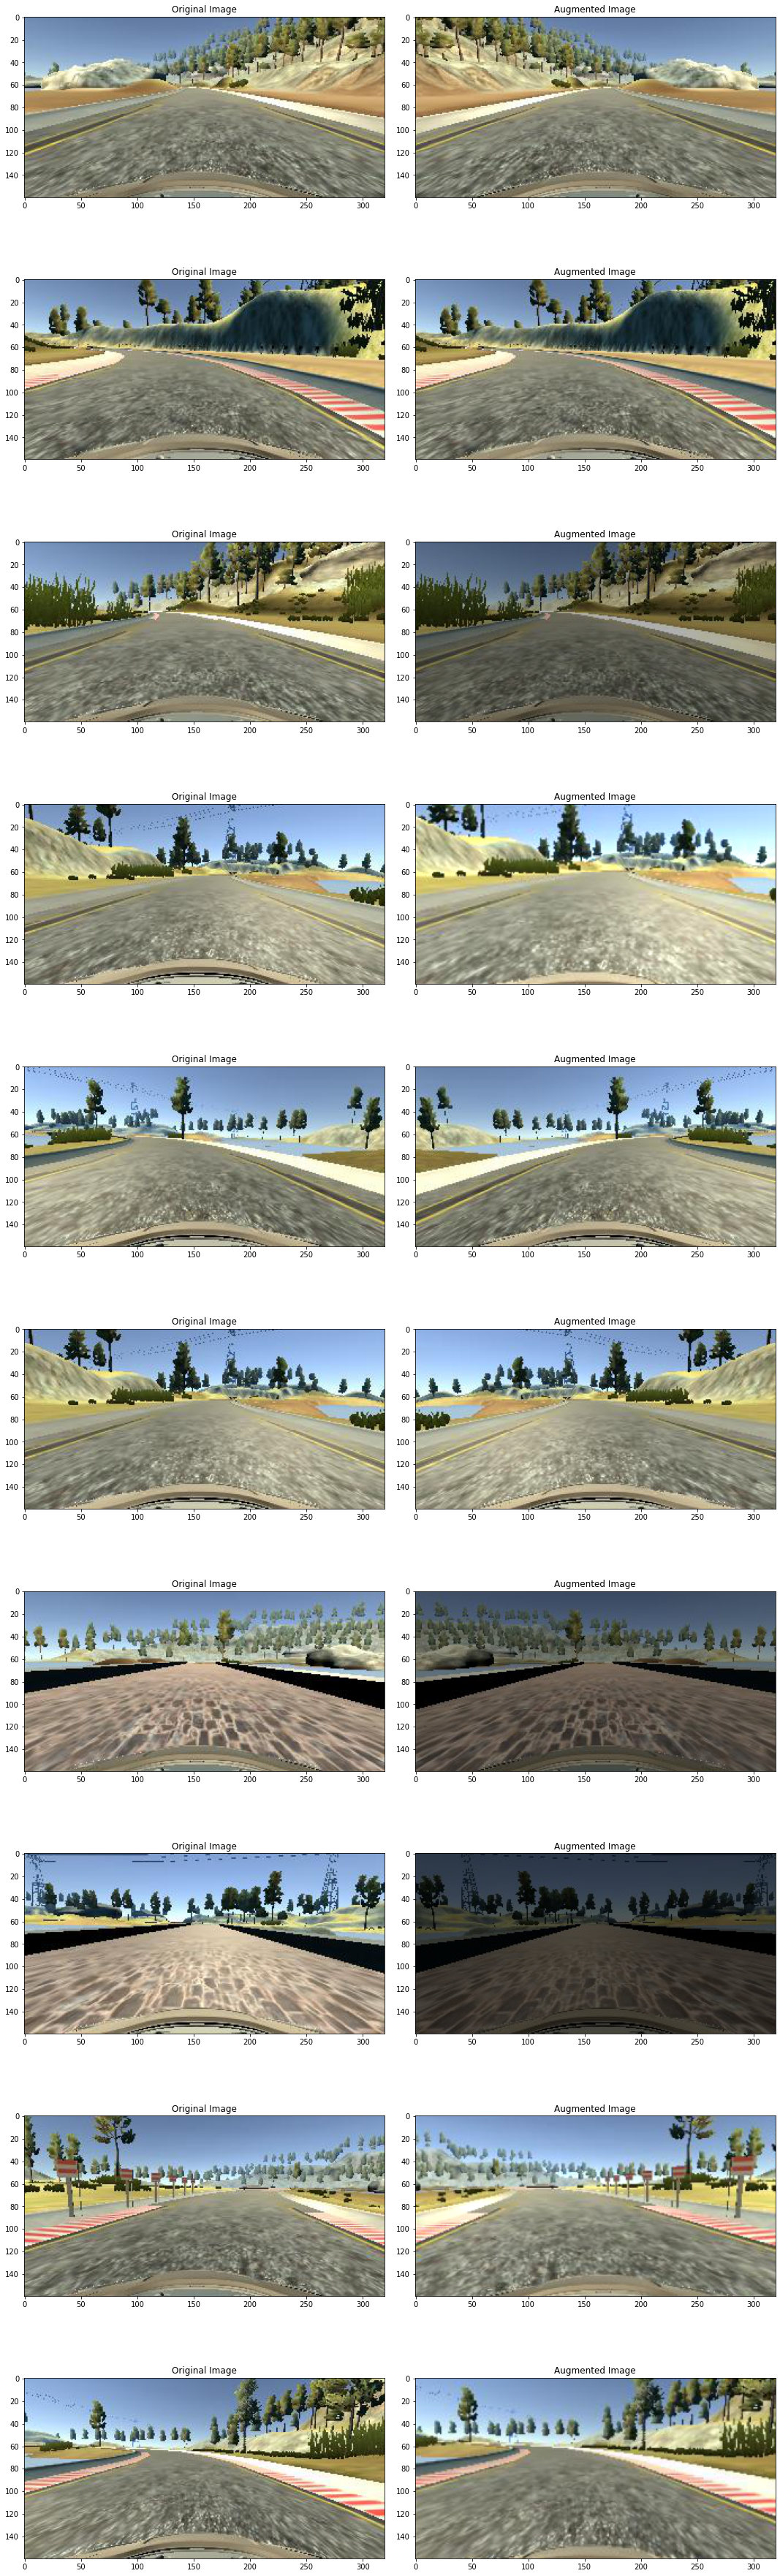

In [23]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [24]:
def img_preprocess(img):
  # img = mpimg.imread(img)
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img,(3,3),0)
  img = cv2.resize(img,(200,66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

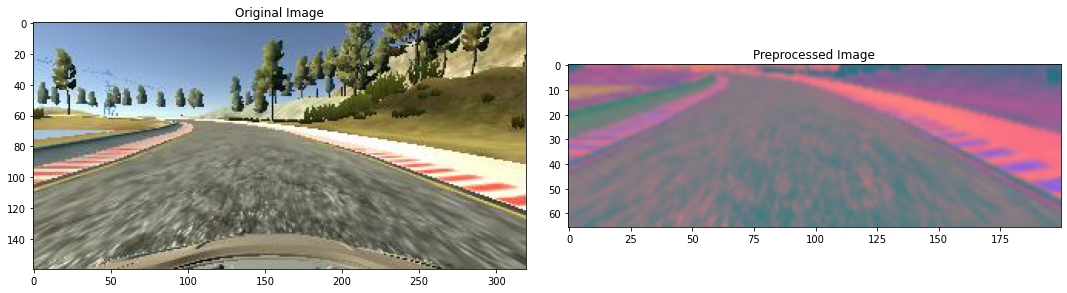

In [25]:
image = image_paths[190]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [26]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering)) 

Text(0.5, 1.0, 'Validation Image')

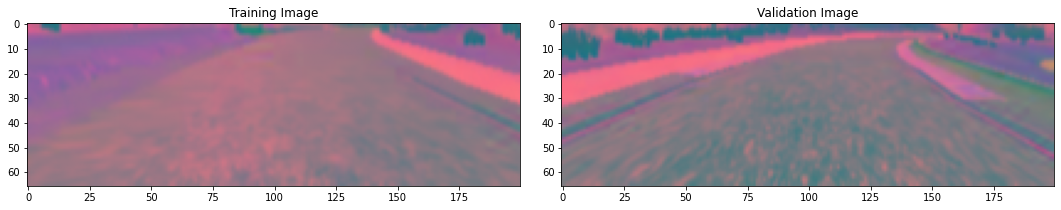

In [27]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [28]:
# run this only once as it tampers the X_train and X_valid sets, if to run again run after re-initialization of train_test_split.
# X_train = np.asarray(list(map(img_preprocess, X_train)))
# X_valid = np.asarray(list(map(img_preprocess, X_valid)))

In [29]:
# plt.imshow(X_train[random.randint(0,len(X_train)-1)])
# plt.axis('on')
# print(X_train.shape)

In [30]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, kernel_size=(5, 5), strides=(2,2), input_shape=(66,200, 3), activation='elu'))
  model.add(Conv2D(36, kernel_size=(5, 5), strides=(1,1), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5, 5), activation='elu'))
  model.add(Conv2D(64, 3, 3, activation='elu'))
  model.add(Conv2D(64, 3, 3, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  # model.add(Dropout(0.5))
  model.add(Dense(50, activation = 'elu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation = 'elu'))
  # model.add(Dropout(0.5))
  model.add(Dense(1))

  optimizer = Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [31]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 94, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 90, 48)        43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 30, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 10, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 2, 10, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0

In [32]:
# history = model.fit(X_train, y_train, epochs=30,validation_data=(X_valid, y_valid),batch_size=100, verbose=1,shuffle = 1)
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
300/300 [==============================] - 172s 574ms/step - loss: 0.0950 - val_loss: 0.0621
Epoch 2/10
300/300 [==============================] - 172s 573ms/step - loss: 0.0667 - val_loss: 0.0503
Epoch 3/10
300/300 [==============================] - 173s 575ms/step - loss: 0.0565 - val_loss: 0.0449
Epoch 4/10
300/300 [==============================] - 172s 574ms/step - loss: 0.0538 - val_loss: 0.0430
Epoch 5/10
300/300 [==============================] - 172s 574ms/step - loss: 0.0505 - val_loss: 0.0422
Epoch 6/10
300/300 [==============================] - 172s 572ms/step - loss: 0.0478 - val_loss: 0.0403
Epoch 7/10
300/300 [==============================] - 172s 572ms/step - loss: 0.0456 - val_loss: 0.0385
Epoch 8/10
300/300 [==============================] - 171s 570ms/step - loss: 0.0435 - val_loss: 0.0390
Epoch 9/10
300/300 [==============================] - 173s 576ms/step - loss: 0.0411 - val_l

Text(0.5, 0, 'Epoch')

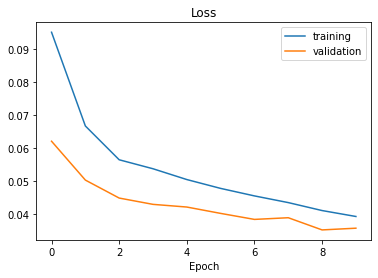

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [34]:
model.save('model.h5', save_format="tf")

In [35]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>